In [55]:
import os
import numpy as np
import pandas as pd
from ydata_profiling import ProfileReport

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from mord import LogisticAT


In [56]:
student_entry_performance_df = pd.read_csv('student_entry_performance_modified.csv')
student_entry_performance_df.head()

,Performance,Gender,Caste,coaching,time,Class_ten_education,twelve_education,medium,Class_ X_Percentage,Class_XII_Percentage,Father_occupation,Mother_occupation,mixed_type_col
0,Excellent,male,General,NO,ONE,SEBA,AHSEC,ENGLISH,Excellent,Excellent,DOCTOR,OTHERS,unknown
1,Excellent,male,OBC,WA,TWO,SEBA,AHSEC,OTHERS,Excellent,Excellent,SCHOOL_TEACHER,HOUSE_WIFE,666
2,Excellent,male,OBC,OA,TWO,OTHERS,CBSE,ENGLISH,Excellent,Excellent,BUSINESS,HOUSE_WIFE,unknown
3,Excellent,male,General,WA,ONE,SEBA,AHSEC,OTHERS,Excellent,Excellent,SCHOOL_TEACHER,SCHOOL_TEACHER,275
4,Excellent,male,General,OA,TWO,NaN,CBSE,ENGLISH,Excellent,Excellent,COLLEGE_TEACHER,HOUSE_WIFE,6


In [90]:
# --- 1. Carga y Limpieza Profunda ---
df = student_entry_performance_df.copy()

In [91]:


# 1a. Unificar valores 'NAN' a np.nan en todo el DataFrame
df.replace('NAN', np.nan, inplace=True)

# 1b. Eliminar la columna problemática
if 'mixed_type_col' in df.columns:
    df.drop('mixed_type_col', axis=1, inplace=True)

# 1c. Eliminar filas donde la variable objetivo es nula
df.dropna(subset=['Performance'], inplace=True)

# --- 2. Feature Engineering y Definición de X/y ---

# 2a. Mapear la columna 'time' a valores numéricos
time_map = {'ONE': 1, 'TWO': 2, 'THREE': 3, 'FOUR': 4, 'FIVE': 5, 'SEVEN': 7}
df['time'] = df['time'].map(time_map)

# 2b. Definir X e y
X = df.drop('Performance', axis=1)
y_texto = df['Performance']

# 2c. Codificar la variable objetivo 'y' respetando el orden
performance_order = ['Average', 'Good', 'Vg', 'Excellent']
target_map = {label: i for i, label in enumerate(performance_order)}
y = y_texto.map(target_map)

In [113]:
# --- 2. VERIFICACIÓN DEL DATAFRAME LIMPIO (ANTES DEL PIPELINE) ---

print("\n--- Verificación de Tipos de Datos y Nulos")
df.info()

display(df.head())


--- Verificación de Tipos de Datos y Nulos
<class 'pandas.core.frame.DataFrame'>
Index: 673 entries, 0 to 678
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Performance           673 non-null    object 
 1   Gender                665 non-null    object 
 2   Caste                 669 non-null    object 
 3   coaching              667 non-null    object 
 4   time                  668 non-null    float64
 5   Class_ten_education   662 non-null    object 
 6   twelve_education      663 non-null    object 
 7   medium                667 non-null    object 
 8   Class_ X_Percentage   667 non-null    object 
 9   Class_XII_Percentage  665 non-null    object 
 10  Father_occupation     669 non-null    object 
 11  Mother_occupation     668 non-null    object 
dtypes: float64(1), object(11)
memory usage: 68.4+ KB


,Performance,Gender,Caste,coaching,time,Class_ten_education,twelve_education,medium,Class_ X_Percentage,Class_XII_Percentage,Father_occupation,Mother_occupation
0,Excellent,male,General,NO,1.0,SEBA,AHSEC,ENGLISH,Excellent,Excellent,DOCTOR,OTHERS
1,Excellent,male,OBC,WA,2.0,SEBA,AHSEC,OTHERS,Excellent,Excellent,SCHOOL_TEACHER,HOUSE_WIFE
2,Excellent,male,OBC,OA,2.0,OTHERS,CBSE,ENGLISH,Excellent,Excellent,BUSINESS,HOUSE_WIFE
3,Excellent,male,General,WA,1.0,SEBA,AHSEC,OTHERS,Excellent,Excellent,SCHOOL_TEACHER,SCHOOL_TEACHER
4,Excellent,male,General,OA,2.0,NaN,CBSE,ENGLISH,Excellent,Excellent,COLLEGE_TEACHER,HOUSE_WIFE


In [ ]:
# --- 3. VERIFICACIÓN DE LA VARIABLE OBJETIVO (y) ---

print("\n--- Conteo de cada clase en 'y' y balance---")
# Confirma que solo hay números
print(y.value_counts().sort_index())

print("\n--- Comparación Directa de 'y' (Original vs. Transformada) ---")
df_verificacion_y = pd.concat([y_texto.rename('y_original'), y.rename('y_transformada')], axis=1)
display(df_verificacion_y)


--- Conteo de cada clase en 'y' ---
Performance
0    158
1    213
2    200
3    102
Name: count, dtype: int64

--- Comparación Directa de 'y' (Original vs. Transformada) ---


,y_original,y_transformada
0,Excellent,3
1,Excellent,3
2,Excellent,3
3,Excellent,3
4,Excellent,3
...,...,...
674,Average,0
675,Average,0
676,Average,0
677,Vg,2


In [94]:
# Columnas que serán codificadas ordinalmente
ordinal_cols = ['Class_ X_Percentage', 'Class_XII_Percentage']

# Columnas que serán tratadas como numéricas (ahora solo 'time')
numeric_cols = ['time']

# Columnas que recibirán One-Hot Encoding
nominal_cols = [
    'Gender', 'Caste', 'coaching', 'Class_ten_education',
    'twelve_education', 'medium', 'Father_occupation', 'Mother_occupation'
]

# Pipeline para datos ordinales categóricos
ordinal_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(categories=[performance_order] * len(ordinal_cols)))
])

# Pipeline para datos nominales (categóricos sin orden)
nominal_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
])

# Pipeline para la única columna numérica ('time')
numeric_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# Unir todos los pipelines en el ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('ordinal', ordinal_pipe, ordinal_cols),
    ('nominal', nominal_pipe, nominal_cols),
    ('numeric', numeric_pipe, numeric_cols)
], remainder='passthrough')



In [95]:
# Transformar los datos y crear el DataFrame final
X_transformado_array = preprocessor.fit_transform(X)
nombres_columnas = preprocessor.get_feature_names_out()
df_transformado = pd.DataFrame(
    X_transformado_array,
    columns=nombres_columnas,
    index=X.index
)

print("\n--- DataFrame Transformado (lo que ve el modelo) ---")
display(df_transformado)


--- DataFrame Transformado (lo que ve el modelo) ---


,ordinal__Class_ X_Percentage,ordinal__Class_XII_Percentage,nominal__Gender_male,nominal__Caste_OBC,nominal__Caste_SC,nominal__Caste_ST,nominal__coaching_OA,nominal__coaching_WA,nominal__Class_ten_education_OTHERS,nominal__Class_ten_education_SEBA,...,nominal__Father_occupation_SCHOOL_TEACHER,nominal__Mother_occupation_BUSINESS,nominal__Mother_occupation_COLLEGE_TEACHER,nominal__Mother_occupation_CULTIVATOR,nominal__Mother_occupation_DOCTOR,nominal__Mother_occupation_ENGINEER,nominal__Mother_occupation_HOUSE_WIFE,nominal__Mother_occupation_OTHERS,nominal__Mother_occupation_SCHOOL_TEACHER,numeric__time
0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,3.0,3.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0
2,3.0,3.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0
3,3.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,3.0,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
674,3.0,3.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0
675,2.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0
676,2.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0
677,3.0,3.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0


In [96]:
# --- 4. Partición Estratificada ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, shuffle=True, random_state=42, stratify=y
)

In [97]:
# --- 6. Modelo y Pipeline Completo ---
elmodelo_XGB = XGBClassifier(
    objective='multi:softprob', eval_metric='mlogloss', random_state=42,
    n_estimators=500, learning_rate=0.1, max_depth=2,
    subsample=0.8, colsample_bytree=0.8, use_label_encoder=False
)

mipipe_xgb = Pipeline(steps=[('preprocesador', preprocessor), ('modelo', elmodelo_XGB)])

# --- 7. Entrenamiento y Evaluación ---
mipipe_xgb.fit(X_train, y_train)
y_pred = mipipe_xgb.predict(X_test)

# Mapear los resultados numéricos de vuelta a texto para un reporte más claro
reverse_target_map = {i: label for label, i in target_map.items()}
y_pred_texto = pd.Series(y_pred).map(reverse_target_map)
y_test_texto = pd.Series(y_test).map(reverse_target_map)

print("\n--- Resultados del Modelo XGBoost en Test ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_test_texto, y_pred_texto, labels=performance_order))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

c:\Users\sleep\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:48:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Resultados del Modelo XGBoost en Test ---
Accuracy: 0.4741

Classification Report:
               precision    recall  f1-score   support

     Average       0.86      0.75      0.80        32
        Good       0.45      0.49      0.47        43
          Vg       0.33      0.33      0.33        40
   Excellent       0.29      0.30      0.29        20

    accuracy                           0.47       135
   macro avg       0.48      0.47      0.47       135
weighted avg       0.49      0.47      0.48       135


Confusion Matrix:
 [[24  4  3  1]
 [ 1 21 15  6]
 [ 1 18 13  8]
 [ 2  4  8  6]]


In [98]:
from sklearn.linear_model import LogisticRegression

# Creando el modelo con parámetros específicos
modelo_logreg_modificado = LogisticRegression(
    C=0.01,                   
    penalty='l1',
    solver='liblinear',
    random_state=42,
    max_iter=1000
)

modelo_logreg = LogisticRegression(random_state=42, max_iter=1000) 

mipipe_logreg = Pipeline(steps=[
    ('preprocesador', preprocessor),
    ('modelo', modelo_logreg)
])


# --- 2. Entrenar el modelo ---
mipipe_logreg.fit(X_train, y_train)


# --- 3. Evaluar el modelo ---
y_pred_logreg = mipipe_logreg.predict(X_test)

# Mapear resultados para el reporte
y_pred_logreg_texto = pd.Series(y_pred_logreg).map(reverse_target_map)

print("\n--- Resultados del Modelo de Regresión Logística en Test ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_logreg):.4f}")
print("\nClassification Report:\n", classification_report(
    y_test_texto,
    y_pred_logreg_texto,
    labels=performance_order
))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_logreg))


--- Resultados del Modelo de Regresión Logística en Test ---
Accuracy: 0.5185

Classification Report:
               precision    recall  f1-score   support

     Average       0.82      0.72      0.77        32
        Good       0.47      0.56      0.51        43
          Vg       0.43      0.50      0.47        40
   Excellent       0.30      0.15      0.20        20

    accuracy                           0.52       135
   macro avg       0.51      0.48      0.49       135
weighted avg       0.52      0.52      0.51       135


Confusion Matrix:
 [[23  5  3  1]
 [ 3 24 14  2]
 [ 1 15 20  4]
 [ 1  7  9  3]]


In [99]:
from sklearn.svm import SVC

# Creando el modelo con parámetros específicos
modelo_svc_modificado = SVC(
    C=5,                      
    kernel='rbf',
    gamma='scale',             
    random_state=42
)

modelo_svc = SVC(random_state=42, probability=True) 

mipipe_svc = Pipeline(steps=[
    ('preprocesador', preprocessor),
    ('modelo', modelo_svc)
])


# --- 2. Entrenar el modelo ---
mipipe_svc.fit(X_train, y_train)


# --- 3. Evaluar el modelo ---
y_pred_svc = mipipe_svc.predict(X_test)

# Mapear resultados para el reporte
y_pred_svc_texto = pd.Series(y_pred_svc).map(reverse_target_map)

print("\n--- Resultados del Modelo SVM (SVC) en Test ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svc):.4f}")
print("\nClassification Report:\n", classification_report(
    y_test_texto,
    y_pred_svc_texto,
    labels=performance_order
))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_svc))


--- Resultados del Modelo SVM (SVC) en Test ---
Accuracy: 0.4963

Classification Report:
               precision    recall  f1-score   support

     Average       0.95      0.66      0.78        32
        Good       0.41      0.56      0.48        43
          Vg       0.39      0.53      0.45        40
   Excellent       1.00      0.05      0.10        20

    accuracy                           0.50       135
   macro avg       0.69      0.45      0.45       135
weighted avg       0.62      0.50      0.48       135


Confusion Matrix:
 [[21  6  5  0]
 [ 0 24 19  0]
 [ 0 19 21  0]
 [ 1  9  9  1]]


In [111]:
# --- 5b. Modelo 2: Regresión Logística Ordinal (Modelo Avanzado) ---
print("\n--- Resultados del Modelo de Regresión Logística Ordinal ---")
pipeline_ordinal = Pipeline(steps=[
    ('preprocesador', preprocessor),
    ('modelo', LogisticAT(alpha=0.01)) 
])
pipeline_ordinal.fit(X_train, y_train)
y_pred_ordinal = pipeline_ordinal.predict(X_test)


# Reporte de resultados
y_pred_ordinal_texto = pd.Series(y_pred_ordinal).map(reverse_target_map)
print(f"Accuracy: {accuracy_score(y_test, y_pred_ordinal):.4f}")
print("\nClassification Report:\n", classification_report(
    y_test_texto,
    y_pred_ordinal_texto,
    labels=performance_order,
    zero_division=0
))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_ordinal))


--- Resultados del Modelo de Regresión Logística Ordinal ---
Accuracy: 0.5111

Classification Report:
               precision    recall  f1-score   support

     Average       1.00      0.62      0.77        32
        Good       0.44      0.44      0.44        43
          Vg       0.42      0.70      0.52        40
   Excellent       0.40      0.10      0.16        20

    accuracy                           0.51       135
   macro avg       0.56      0.47      0.47       135
weighted avg       0.56      0.51      0.50       135


Confusion Matrix:
 [[20 10  2  0]
 [ 0 19 24  0]
 [ 0  9 28  3]
 [ 0  5 13  2]]


In [101]:
%matplotlib inline
def plot_learning_curves(estimator, title, X, y, cv=5, n_jobs=-1):

    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy'
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')

    plt.plot(train_sizes, val_mean, color='green', linestyle='--', marker='+', markersize=5, label='Validation Accuracy')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.15, color='green')

    plt.title(title)
    plt.xlabel('Tamaño de la muestra de entrenamiento')
    plt.ylabel('Accuracy (Precisión)')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

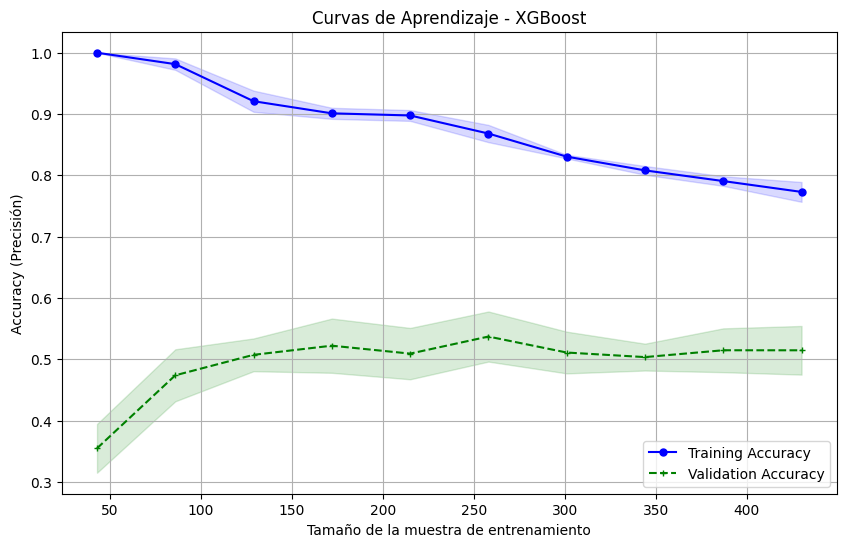

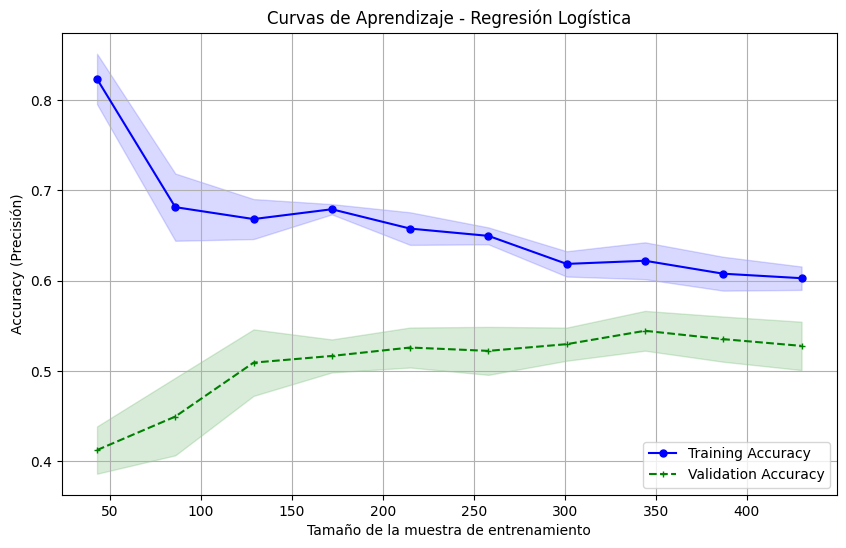

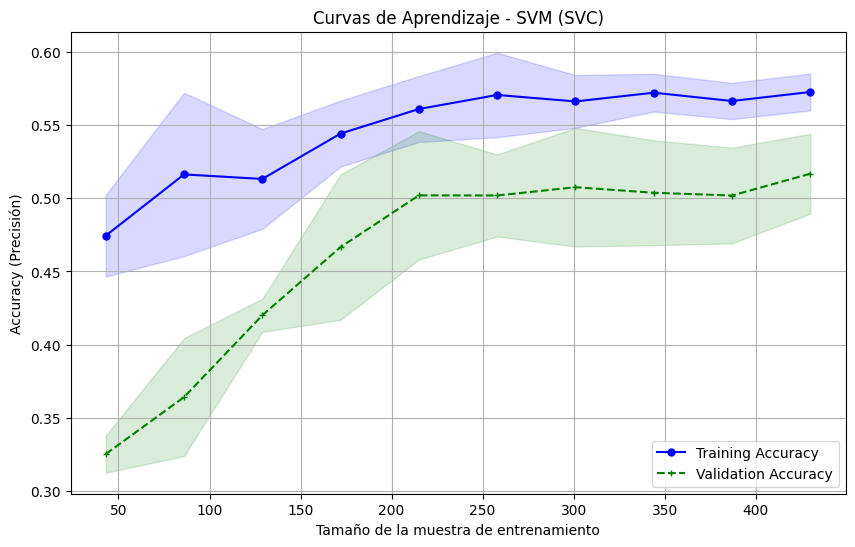

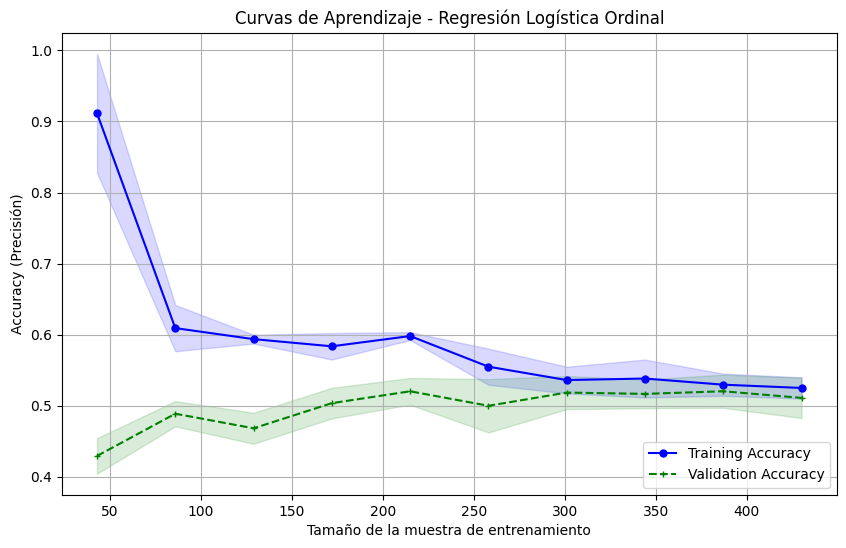

In [112]:
# --- Graficar para XGBoost ---
plot_learning_curves(mipipe_xgb, "Curvas de Aprendizaje - XGBoost", X_train, y_train)

# --- Graficar para Regresión Logística ---
plot_learning_curves(mipipe_logreg, "Curvas de Aprendizaje - Regresión Logística", X_train, y_train)

# --- Graficar para SVM (SVC) ---
plot_learning_curves(mipipe_svc, "Curvas de Aprendizaje - SVM (SVC)", X_train, y_train)

# --- Graficar para Regresión Logística Ordinal ---
plot_learning_curves(pipeline_ordinal, "Curvas de Aprendizaje - Regresión Logística Ordinal", X_train, y_train)